# GRU Models for Sentiment Analysis

## Overview
This notebook implements GRU (Gated Recurrent Unit) architecture for Twitter sentiment classification using three different embedding approaches.

## Models
1. **GRU with TF-IDF Features**
2. **GRU with Skip-gram Embeddings (Word2Vec)**
3. **GRU with CBOW Embeddings (Word2Vec)**

## Evaluation Metrics
- Accuracy
- Precision, Recall, F1-Score
- Confusion Matrix
- Classification Report

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Text preprocessing
import re
import nltk

# Feature extraction & Embeddings
from sklearn.feature_extraction.text import TfidfVectorizer

# Install gensim if not already installed
!pip install gensim -q
from gensim.models import Word2Vec

# Deep Learning (GRU Implementation)
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    GRU, Dense, Embedding, Dropout, SpatialDropout1D,
    Bidirectional, Input, Reshape
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Model evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
import warnings
import os
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("✓ Libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 30.0 MB/s eta 0:00:00
✓ Libraries imported successfully!
TensorFlow version: 2.19.0
GPU Available: False


# Step 1: Data Sanitization & Label Mapping




In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# 1. Load the raw dataset
# The dataset contains 'clean_text' and 'category' (-1, 0, 1)
df = pd.read_csv('/content/drive/MyDrive/sentiment-analysis/data/raw/Twitter_Data.csv')

# 2. Basic Cleaning
# Remove any rows where text or category is missing
df = df.dropna(subset=['clean_text', 'category'])

# 3. Label Remapping
# GRU output layers start at index 0.
# We map: -1 (Negative) -> 0, 0 (Neutral) -> 1, 1 (Positive) -> 2
label_map = {-1.0: 0, 0.0: 1, 1.0: 2, -1: 0, 0: 1, 1: 2}
df['label_encoded'] = df['category'].map(label_map).astype(int)

# 4. Final Verification
# Ensure we only have classes 0, 1, and 2 to prevent "InvalidArgumentError"
df = df[df['label_encoded'].isin([0, 1, 2])].reset_index(drop=True)

print("✓ Step 1 Complete: Labels Sanitized")
print("-" * 30)
print("New Label Distribution:")
print(df['label_encoded'].value_counts().sort_index())

# 5. Global Constants for all Experiments
MAX_NB_WORDS = 20000
MAX_SEQUENCE_LENGTH = 100
EMBEDDING_DIM = 128

# 6. Initial Split
# We split into Train and a 'Temp' set for further validation/test splitting
X = df['clean_text'].values.astype(str)
y = df['label_encoded'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining samples: {len(X_train):,}")
print(f"Testing samples:  {len(X_test):,}")

✓ Step 1 Complete: Labels Sanitized
------------------------------
New Label Distribution:
label_encoded
0    35509
1    55211
2    72249
Name: count, dtype: int64

Training samples: 130,375
Testing samples:  32,594


# Step 2: Tokenization & Sequence Preparation

In [5]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Initialize the Tokenizer
# We use MAX_NB_WORDS (20,000) to keep the vocabulary manageable
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# 2. Convert text strings to sequences of integers
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# 3. Pad sequences to a fixed length
# We use 'pre' padding to ensure the GRU doesn't "forget" the text content
X_train_padded = pad_sequences(X_train_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='post')
X_test_padded = pad_sequences(X_test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='pre', truncating='post')

# 4. Verify the transformation
print("✓ Step 2 Complete: Text Tokenized and Padded")
print("-" * 30)
print(f"Vocabulary Size: {len(tokenizer.word_index):,}")
print(f"Shape of Training Data: {X_train_padded.shape}")
print(f"Example of a padded sequence (first 10 elements):\n{X_train_padded[0][:10]}")

✓ Step 2 Complete: Text Tokenized and Padded
------------------------------
Vocabulary Size: 98,759
Shape of Training Data: (130375, 100)
Example of a padded sequence (first 10 elements):
[0 0 0 0 0 0 0 0 0 0]


# 2. Train Skip-gram Model (sg=1)

In [6]:
from gensim.models import Word2Vec
import numpy as np

# 1. Prepare sentences for Word2Vec training
# We split each tweet into a list of words
sentences_train = [text.split() for text in X_train]

# 2. Train Skip-gram Model (sg=1)
print("Training Skip-gram (Word2Vec) model...")
sg_w2v_model = Word2Vec(
    sentences=sentences_train,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=1, # 1 for Skip-gram
    epochs=10,
    seed=42
)

Training Skip-gram (Word2Vec) model...


# 3. Train CBOW Model (sg=0)

In [7]:
print("Training CBOW (Word2Vec) model...")
cbow_w2v_model = Word2Vec(
    sentences=sentences_train,
    vector_size=EMBEDDING_DIM,
    window=5,
    min_count=2,
    workers=4,
    sg=0, # 0 for CBOW
    epochs=10,
    seed=42
)

print("\n✓ Word2Vec training complete!")

Training CBOW (Word2Vec) model...

✓ Word2Vec training complete!


# 3.2 Create the Embedding Matrices

In [8]:
def create_embedding_matrix(w2v_model, tokenizer, max_words, embedding_dim):
    # Initialize matrix with zeros
    vocab_size = min(max_words, len(tokenizer.word_index) + 1)
    embedding_matrix = np.zeros((vocab_size, embedding_dim), dtype='float32')

    matched_count = 0
    for word, i in tokenizer.word_index.items():
        if i >= max_words:
            continue
        if word in w2v_model.wv:
            embedding_matrix[i] = w2v_model.wv[word]
            matched_count += 1

    print(f"Matched {matched_count}/{vocab_size-1} words ({matched_count/(vocab_size-1)*100:.2f}%)")
    return embedding_matrix

# Generate the two separate matrices
print("\nCreating Skip-gram Embedding Matrix:")
sg_matrix = create_embedding_matrix(sg_w2v_model, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM)

print("\nCreating CBOW Embedding Matrix:")
cbow_matrix = create_embedding_matrix(cbow_w2v_model, tokenizer, MAX_NB_WORDS, EMBEDDING_DIM)


Creating Skip-gram Embedding Matrix:
Matched 19982/19999 words (99.91%)

Creating CBOW Embedding Matrix:
Matched 19982/19999 words (99.91%)


# Step 4: Building the GRU Architecture & Training

## 4.1 Define the GRU Model Function

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

def build_gru_model(embedding_matrix, max_len, vocab_size, embedding_dim):
    model = Sequential([
        # Initialize with our pre-trained Word2Vec weights
        Embedding(
            input_dim=vocab_size,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=max_len,
            trainable=True  # Fine-tune the embeddings for sentiment
        ),
        SpatialDropout1D(0.3),

        # Bidirectional GRU to capture context from both directions
        Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0)), # recurrent_dropout=0 for GPU speed

        # Hidden layer for complexity
        Dense(32, activation='relu'),
        Dropout(0.3),

        # Output layer: 3 units for labels 0 (Neg), 1 (Neu), 2 (Pos)
        Dense(3, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Define standard callbacks for both experiments
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)
]

# 4.2 Experiment 2: Train GRU + Skip-gram

In [10]:
vocab_size_sg = sg_matrix.shape[0]

print("🚀 Starting Experiment: GRU + Skip-gram")
model_sg = build_gru_model(sg_matrix, MAX_SEQUENCE_LENGTH, vocab_size_sg, EMBEDDING_DIM)

history_sg = model_sg.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1, # Use 10% of training data for validation
    callbacks=callbacks,
    verbose=1
)

🚀 Starting Experiment: GRU + Skip-gram
Epoch 1/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 546s 295ms/step - accuracy: 0.6712 - loss: 0.7146 - val_accuracy: 0.9496 - val_loss: 0.1662 - learning_rate: 0.0010
Epoch 2/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 558s 304ms/step - accuracy: 0.9421 - loss: 0.1848 - val_accuracy: 0.9676 - val_loss: 0.1090 - learning_rate: 0.0010
Epoch 3/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 560s 305ms/step - accuracy: 0.9647 - loss: 0.1147 - val_accuracy: 0.9734 - val_loss: 0.0923 - learning_rate: 0.0010
Epoch 4/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 559s 305ms/step - accuracy: 0.9745 - loss: 0.0870 - val_accuracy: 0.9742 - val_loss: 0.0917 - learning_rate: 0.0010
Epoch 5/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 563s 305ms/step - accuracy: 0.9783 - loss: 0.0723 - val_accuracy: 0.9748 - val_loss: 0.0925 - learning_rate: 0.0010
Epoch 6/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9817 - loss: 0.0598
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
1834/

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 37s 36ms/step
RESULTS: GRU + Skip-gram
Accuracy:  0.9737
Precision: 0.9739
Recall:    0.9737
F1-Score:  0.9737
------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

    Negative       0.97      0.94      0.96      7102
     Neutral       0.99      0.98      0.98     11042
    Positive       0.96      0.99      0.97     14450

    accuracy                           0.97     32594
   macro avg       0.98      0.97      0.97     32594
weighted avg       0.97      0.97      0.97     32594



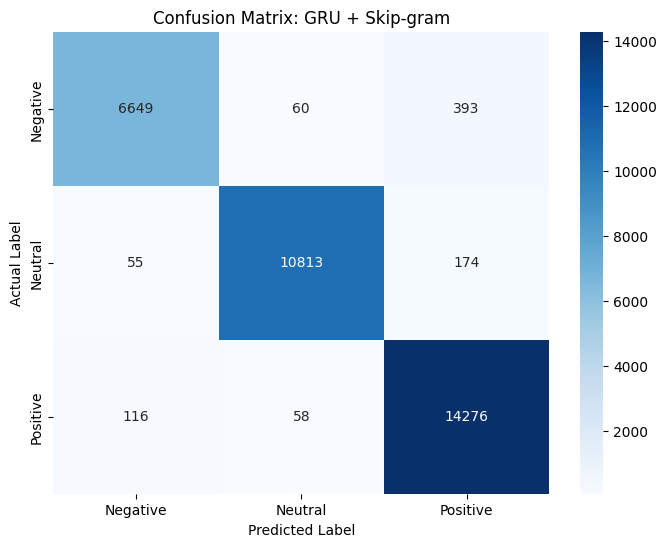

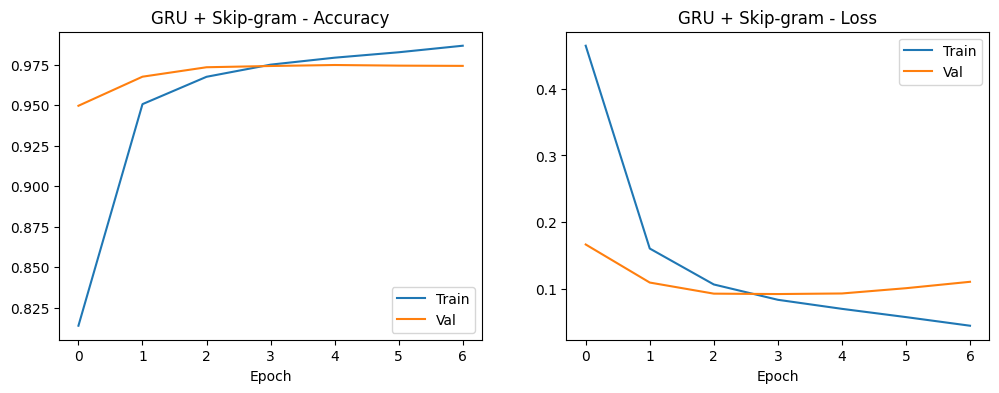

In [11]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Generate Predictions
# We predict on the test set we prepared in Step 2
y_pred_probs = model_sg.predict(X_test_padded)
y_pred = np.argmax(y_pred_probs, axis=1)

# 2. Calculate Standard Metrics
accuracy = accuracy_score(y_test, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')

print("="*60)
print(f"RESULTS: GRU + Skip-gram")
print("="*60)
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print("-" * 60)

# 3. Detailed Classification Report
# Target names mapped to our sanitized labels
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

# 4. Visualization: Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix: GRU + Skip-gram')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Visualization: Training History
def plot_history(history, title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Accuracy Plot
    ax1.plot(history.history['accuracy'], label='Train')
    ax1.plot(history.history['val_accuracy'], label='Val')
    ax1.set_title(f'{title} - Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()

    # Loss Plot
    ax2.plot(history.history['loss'], label='Train')
    ax2.plot(history.history['val_loss'], label='Val')
    ax2.set_title(f'{title} - Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    plt.show()

plot_history(history_sg, "GRU + Skip-gram")

# 4.3 Experiment 3: Train GRU + CBOW

In [12]:
# 1. Get the vocabulary size for the CBOW matrix
vocab_size_cbow = cbow_matrix.shape[0]

print("🚀 Starting Experiment: GRU + CBOW")

# 2. Build the model using the same architecture but with CBOW weights
model_cbow = build_gru_model(cbow_matrix, MAX_SEQUENCE_LENGTH, vocab_size_cbow, EMBEDDING_DIM)

# 3. Train the model
# We use the same parameters and callbacks as the Skip-gram experiment
history_cbow = model_cbow.fit(
    X_train_padded, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

🚀 Starting Experiment: GRU + CBOW
Epoch 1/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 618s 333ms/step - accuracy: 0.5829 - loss: 0.8627 - val_accuracy: 0.9130 - val_loss: 0.2597 - learning_rate: 0.0010
Epoch 2/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 636s 347ms/step - accuracy: 0.8978 - loss: 0.2986 - val_accuracy: 0.9530 - val_loss: 0.1482 - learning_rate: 0.0010
Epoch 3/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 582s 317ms/step - accuracy: 0.9393 - loss: 0.1798 - val_accuracy: 0.9645 - val_loss: 0.1188 - learning_rate: 0.0010
Epoch 4/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 644s 329ms/step - accuracy: 0.9555 - loss: 0.1342 - val_accuracy: 0.9682 - val_loss: 0.1073 - learning_rate: 0.0010
Epoch 5/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 621s 339ms/step - accuracy: 0.9630 - loss: 0.1122 - val_accuracy: 0.9694 - val_loss: 0.1008 - learning_rate: 0.0010
Epoch 6/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 621s 338ms/step - accuracy: 0.9695 - loss: 0.0945 - val_accuracy: 0.9704 - val_loss: 0.0996 - learning_rate: 0.0010
Epoch 7/10
1834/18

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 52s 47ms/step
RESULTS: GRU + CBOW
Accuracy:  0.9696
Precision: 0.9698
Recall:    0.9696
F1-Score:  0.9697
------------------------------------------------------------

Classification Report (CBOW):
              precision    recall  f1-score   support

    Negative       0.94      0.95      0.94      7102
     Neutral       0.99      0.98      0.98     11042
    Positive       0.97      0.98      0.97     14450

    accuracy                           0.97     32594
   macro avg       0.97      0.97      0.97     32594
weighted avg       0.97      0.97      0.97     32594



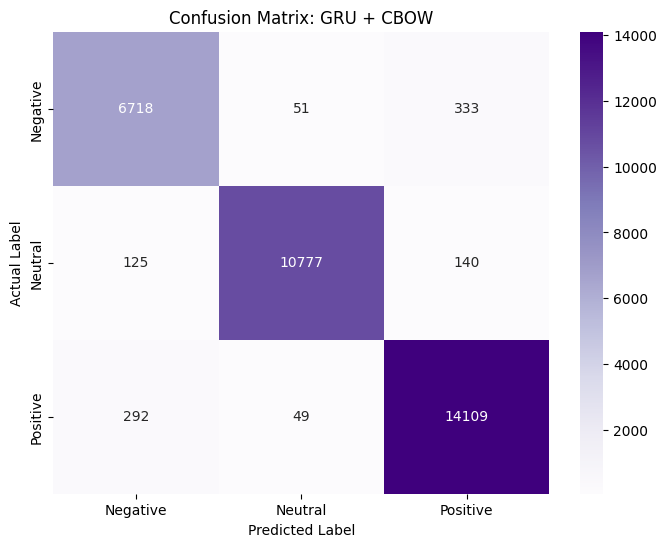

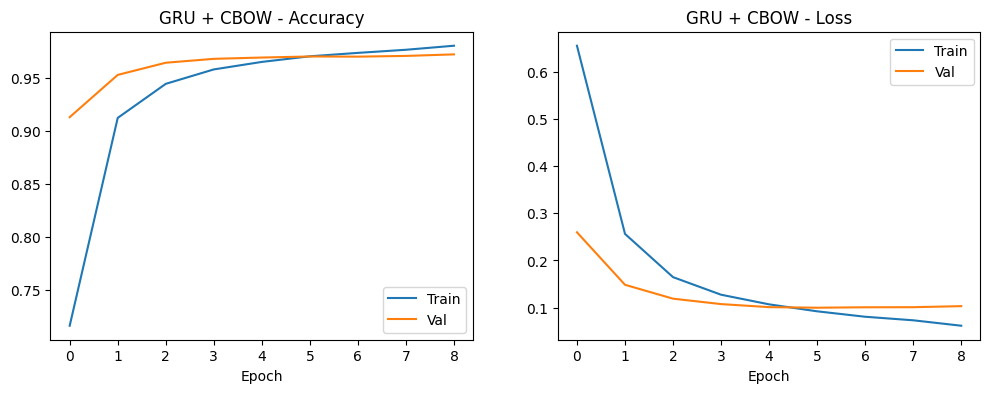

In [13]:
# 1. Generate Predictions for the CBOW model
y_pred_probs_cbow = model_cbow.predict(X_test_padded)
y_pred_cbow = np.argmax(y_pred_probs_cbow, axis=1)

# 2. Calculate Metrics
accuracy_cbow = accuracy_score(y_test, y_pred_cbow)
precision_cbow, recall_cbow, f1_cbow, _ = precision_recall_fscore_support(y_test, y_pred_cbow, average='weighted')

print("="*60)
print(f"RESULTS: GRU + CBOW")
print("="*60)
print(f"Accuracy:  {accuracy_cbow:.4f}")
print(f"Precision: {precision_cbow:.4f}")
print(f"Recall:    {recall_cbow:.4f}")
print(f"F1-Score:  {f1_cbow:.4f}")
print("-" * 60)

# 3. Detailed Classification Report
print("\nClassification Report (CBOW):")
print(classification_report(y_test, y_pred_cbow, target_names=['Negative', 'Neutral', 'Positive']))

# 4. Visualization: Confusion Matrix
plt.figure(figsize=(8, 6))
cm_cbow = confusion_matrix(y_test, y_pred_cbow)
sns.heatmap(cm_cbow, annot=True, fmt='d', cmap='Purples',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix: GRU + CBOW')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. Visualization: Training History
plot_history(history_cbow, "GRU + CBOW")

# Step 5: Experiment 1 (GRU + TF-IDF)

## 5.1 Vectorization & 3D Reshaping

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. Initialize TF-IDF Vectorizer
# We limit to 3,000 features to balance detail with memory efficiency
tfidf_vectorizer = TfidfVectorizer(max_features=3000)

# 2. Fit and Transform
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train).toarray().astype('float32')
X_test_tfidf = tfidf_vectorizer.transform(X_test).toarray().astype('float32')

# 3. Reshape for GRU Input
# GRU requires (batch, timesteps, features).
# We'll treat the 3,000 features as 30 timesteps of 100 features each.
timesteps = 30
features_per_step = 100

X_train_tfidf_3d = X_train_tfidf.reshape(-1, timesteps, features_per_step)
X_test_tfidf_3d = X_test_tfidf.reshape(-1, timesteps, features_per_step)

print(f"✓ TF-IDF Reshaped for GRU: {X_train_tfidf_3d.shape}")

✓ TF-IDF Reshaped for GRU: (130375, 30, 100)


In [15]:
from tensorflow.keras.layers import Input

def build_gru_tfidf_model(timesteps, features):
    model = Sequential([
        Input(shape=(timesteps, features)),
        Bidirectional(GRU(64, dropout=0.2, recurrent_dropout=0)),
        Dense(32, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Train Experiment 1
print("🚀 Starting Experiment: GRU + TF-IDF")
model_tfidf = build_gru_tfidf_model(timesteps, features_per_step)

history_tfidf = model_tfidf.fit(
    X_train_tfidf_3d, y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.1,
    callbacks=callbacks,
    verbose=1
)

🚀 Starting Experiment: GRU + TF-IDF
Epoch 1/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 116s 60ms/step - accuracy: 0.5118 - loss: 0.9866 - val_accuracy: 0.6702 - val_loss: 0.7899 - learning_rate: 0.0010
Epoch 2/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 104s 57ms/step - accuracy: 0.6473 - loss: 0.8132 - val_accuracy: 0.6828 - val_loss: 0.7448 - learning_rate: 0.0010
Epoch 3/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 141s 56ms/step - accuracy: 0.6735 - loss: 0.7655 - val_accuracy: 0.7117 - val_loss: 0.6994 - learning_rate: 0.0010
Epoch 4/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 141s 56ms/step - accuracy: 0.6921 - loss: 0.7371 - val_accuracy: 0.7279 - val_loss: 0.6660 - learning_rate: 0.0010
Epoch 5/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 144s 57ms/step - accuracy: 0.7078 - loss: 0.7085 - val_accuracy: 0.7487 - val_loss: 0.6272 - learning_rate: 0.0010
Epoch 6/10
1834/1834 ━━━━━━━━━━━━━━━━━━━━ 139s 55ms/step - accuracy: 0.7184 - loss: 0.6865 - val_accuracy: 0.7579 - val_loss: 0.6120 - learning_rate: 0.0010
Epoch 7/10
1834/1834 ━

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step
TF-IDF Accuracy: 0.7761 | F1-Score: 0.7734


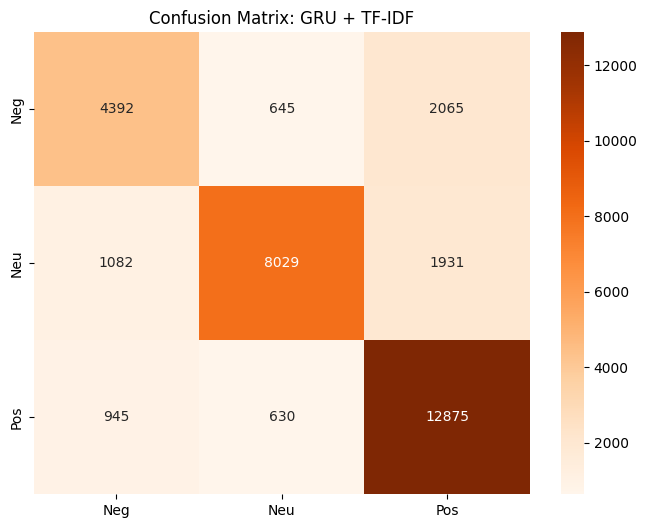

In [16]:
# 1. Predictions
y_pred_tfidf = np.argmax(model_tfidf.predict(X_test_tfidf_3d), axis=1)

# 2. Metrics
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
p_tfidf, r_tfidf, f1_tfidf, _ = precision_recall_fscore_support(y_test, y_pred_tfidf, average='weighted')

print(f"TF-IDF Accuracy: {acc_tfidf:.4f} | F1-Score: {f1_tfidf:.4f}")

# 3. Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_tfidf), annot=True, fmt='d', cmap='Oranges',
            xticklabels=['Neg', 'Neu', 'Pos'], yticklabels=['Neg', 'Neu', 'Pos'])
plt.title('Confusion Matrix: GRU + TF-IDF')
plt.show()

             GRU MODEL PERFORMANCE COMPARISON
Embedding Technique  Accuracy  Precision   Recall  F1-Score
             TF-IDF  0.776094   0.779762 0.776094  0.773410
          Skip-gram  0.973737   0.973944 0.973737  0.973669
               CBOW  0.969626   0.969770 0.969626  0.969669


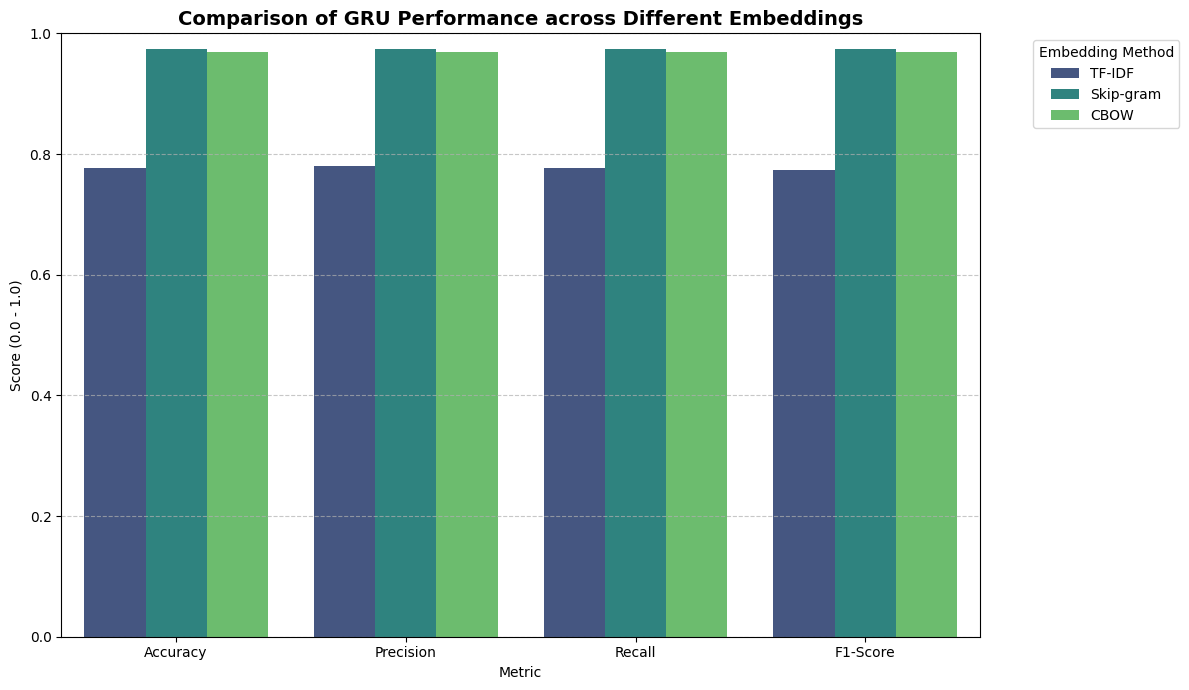


✓ Results saved to 'gru_comparative_analysis.csv'


In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Create a Results DataFrame
# We collect the metrics calculated in the previous steps for comparison
results_data = {
    'Embedding Technique': ['TF-IDF', 'Skip-gram', 'CBOW'],
    'Accuracy': [acc_tfidf, accuracy, accuracy_cbow],
    'Precision': [p_tfidf, precision, precision_cbow],
    'Recall': [r_tfidf, recall, recall_cbow],
    'F1-Score': [f1_tfidf, f1, f1_cbow]
}

df_results = pd.DataFrame(results_data)

# 2. Display the Results Table
print("="*65)
print("             GRU MODEL PERFORMANCE COMPARISON")
print("="*65)
print(df_results.to_string(index=False))
print("="*65)

# 3. Visualization: Grouped Bar Chart
# This helps in the "Comparative Analysis" section of your report
df_melted = df_results.melt(id_vars='Embedding Technique', var_name='Metric', value_name='Score')

plt.figure(figsize=(12, 7))
sns.barplot(data=df_melted, x='Metric', y='Score', hue='Embedding Technique', palette='viridis')
plt.title('Comparison of GRU Performance across Different Embeddings', fontsize=14, fontweight='bold')
plt.ylim(0, 1.0)
plt.ylabel('Score (0.0 - 1.0)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Embedding Method', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Save Results for your Report
df_results.to_csv('gru_comparative_analysis.csv', index=False)
print("\n✓ Results saved to 'gru_comparative_analysis.csv'")